# Outcome Analysis

## Housekeeping

In [1]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-4PHX9XhMUWpi_lTsGHtTyz6s3O0u5a2/ds1_nhanes


Packages needed for this notebook:

In [2]:
# Utilities
import sys
import numpy as np
import pandas as pd

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Stat things
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Neat interactive tables
# if 'google.colab' in sys.modules:
#   !pip install itables
# import itables

Loading dataset with cluster assignments and HEI scores

In [3]:
df = pd.read_csv('data/clean/nhanes_2017_2023_hei.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11394 entries, 0 to 11393
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       11394 non-null  int64  
 1   weight_2d                  11394 non-null  float64
 2   pf_total_(oz_eq)           11394 non-null  float64
 3   pf_legumes_(oz_eq)         11394 non-null  float64
 4   pf_nutsds_(oz_eq)          11394 non-null  float64
 5   pf_soy_(oz_eq)             11394 non-null  float64
 6   psu                        11394 non-null  int64  
 7   strata                     11394 non-null  int64  
 8   gender                     11394 non-null  object 
 9   age                        11394 non-null  int64  
 10  education                  11394 non-null  object 
 11  income_ratio               11394 non-null  float64
 12  total_cholesterol          11394 non-null  int64  
 13  blood_mercury              11394 non-null  flo

### Palette and Theme

In [4]:
# Commenting this out so we have plain old figs for the paper
# Keeping the palette and font size though

# font_path = 'dev/fonts/static/Raleway-Regular.ttf'
# fontprop = fm.FontProperties(fname=font_path)
# raleway = fontprop.get_name()
# fm.fontManager.addfont(font_path)

# Set theme
our_palette=[
    '#fff8eb',
    '#fa073b',
    '#2a7578',
    '#c8b054',
    '#390918',
    '#f49425'
]

# Change font size here, title will automatically be bigger
font_size = 12

# Set defaults for matplotlib and seaborn plots
plt.rcParams.update({
    # 'font.family': raleway,
    'font.size': font_size,
    'axes.titlesize': font_size + 4
    # 'axes.facecolor': our_palette[0],
    # 'figure.facecolor': our_palette[0]
    # 'axes.facecolor': '#FFF3D9',
    # 'figure.facecolor': '#FFF3D9'
})

## Set up R Magic

Loading R libraries from Drive. Colab is a bottomless pit of despair, so instead of taking 20 minutes to install a couple of packages every time we start a session, we have saved some R packages to the drive that we can load much faster.

In [5]:
# Enables R magic
%load_ext rpy2.ipython

ERROR:rpy2.situation:Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [6]:
%%R
# %%R has to be at the top of every cell that runs R

# This is adding our drive library to paths that R will check when it loads packages
.libPaths(c("dev/r_library/library", .libPaths()))

In [7]:
%%R
library(survey) # Loading survey for complex survey analysis
library(dplyr) # Also dplyr for various data wrangling functions
library(broom) # Broom gives us nice clean tables from stat outputs with tidy() function
library(purrr) # Purrr is convenient for iterating, working with lists
library(tibble) # Extension of data frames with useful wrangling functions
library(stringr) # for working with strings
library(tidyr) # for tidying data


Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



In [8]:
%%R
# Setting up lists to hold results that we can throw together
anovas <- list()
posthocs <- list()

Load some python libraries so that we can hand off data from R back to python

In [9]:
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

Load data:

In [10]:
%%R
# read.csv is like pd.read_csv
# Usually use '<-' instead of '=' for assigning objects, but either way works
dat <- read.csv('data/clean/nhanes_2017_2023_hei.csv')

# str() is like .info()
str(dat)

'data.frame':	11394 obs. of  41 variables:
 $ SEQN                     : int  109266 109271 109273 109274 109282 109284 109286 109290 109291 109293 ...
 $ weight_2d                : num  2994 7989 28256 6187 25233 ...
 $ pf_total_.oz_eq.         : num  2.79 19.54 8.14 7.48 7.22 ...
 $ pf_legumes_.oz_eq.       : num  1.63 0 0 0 0 ...
 $ pf_nutsds_.oz_eq.        : num  0.115 0 0 0 0.529 ...
 $ pf_soy_.oz_eq.           : num  0.783 0.072 0 0 0.012 0 0.009 0 0 0 ...
 $ psu                      : int  2 1 1 2 2 1 2 1 1 2 ...
 $ strata                   : int  168 167 155 167 164 154 154 171 161 163 ...
 $ gender                   : chr  "Female" "Male" "Male" "Male" ...
 $ age                      : int  29 49 36 68 76 44 33 68 42 44 ...
 $ education                : chr  "College graduate or above" "9th to 11th grade" "Some college or AA" "Some college or AA" ...
 $ income_ratio             : num  5 0.67 0.83 1.2 3.61 3.15 1.36 5 5 0.02 ...
 $ total_cholesterol        : int  195 147 164 10

Do some cleaning to prepare to create survey design object

In [11]:
%%R
# Remove irrelevant columns
# We are using select and assigning the result back to dat
dat <- select(
    dat,
    psu,
    strata,
    weight_2d,
    gender:cluster,
    race,
    hei_score,
    starts_with('prop_'),
    matches('_density$|_ratio$|_pct$'),
    alcoholic_drinks = starts_with('a_')
)

# Make characters factors, split age into bins
# Mutate function creates new columns
dat <- dat %>%
  mutate(
    gender = factor(gender),
    education_num = case_when(
      education == "Less than 9th grade" ~ 1,
      education == "9th to 11th grade" ~ 2,
      education == "High school/GED" ~ 3,
      education == "Some college or AA" ~ 4,
      education == "College graduate or above" ~ 5,
      .default = NA
    ),
    education = factor(education),
    race = factor(race),
    cluster = factor(cluster),
    age_bins = cut(
      age,
      breaks = c(-Inf, 19, 29, 39, 49, 59, Inf),
      labels = c(
        "<20",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60+"
      )
    )
  )

str(dat)

'data.frame':	11394 obs. of  37 variables:
 $ psu                      : int  2 1 1 2 2 1 2 1 1 2 ...
 $ strata                   : int  168 167 155 167 164 154 154 171 161 163 ...
 $ weight_2d                : num  2994 7989 28256 6187 25233 ...
 $ gender                   : Factor w/ 2 levels "Female","Male": 1 2 2 2 2 1 1 1 1 2 ...
 $ age                      : int  29 49 36 68 76 44 33 68 42 44 ...
 $ education                : Factor w/ 6 levels "9th to 11th grade",..: 2 1 6 6 2 1 2 2 2 4 ...
 $ income_ratio             : num  5 0.67 0.83 1.2 3.61 3.15 1.36 5 5 0.02 ...
 $ total_cholesterol        : int  195 147 164 105 233 212 236 165 229 189 ...
 $ blood_mercury            : num  0.36 0.42 0.51 0.2 0.31 0.54 1.44 1.22 0.6 0.63 ...
 $ avg_systolic_bp          : num  99 107 114 134 139 ...
 $ avg_diastolic_bp         : num  54.3 67 67.3 70 72.7 ...
 $ cluster                  : Factor w/ 4 levels "1","2","3","4": 2 1 2 2 2 2 4 3 3 2 ...
 $ race                     : Factor w/ 6 le

Make survey design object. This takes all the relics of our complex survey design and will incorporate it into any analyses. We will then use this 'design' object as the dataset for everything.

In [12]:
%%R
design <- svydesign(
  data = dat,
  id =  ~ psu,
  strata =  ~ strata,
  weights =  ~ weight_2d,
  nest = TRUE
)

### Custom Functions

Making a function that gives us our R2 for OLS models, because it is a bit different than regular OLS and not given by default. This is mostly pulled from a [Stack Exchange post](https://stats.stackexchange.com/questions/424092/how-to-run-svy-regress-in-r-or-get-r-squared-in-r-for-complex-survey-data) by Thomas Lumley, author of R survey package, where he describes how to get R2 using as:

>R^2 = 1 - (Dispersion parameter / variance of the null model)

In [13]:
%%R
get_r2 <- function(model, outcome_var, design = design) {

  # Throw an error if trying to use this on anything other than Gaussian model
  if (family(model)$family != "gaussian") {
    stop("Only for linear models")
  }

  # Get dispersion parameter from model
  dispersion <- summary(model)$dispersion

  # Get variance of the null model
  variance <- svyvar(reformulate(outcome_var), design = design)[1]

  # Calculate R^2
  r2 <- 1 - (dispersion / variance)
  return(r2)
}

Also adding a function for post-hoc tests of ANOVA. There is nothing built into survey package. We are just running weighted t tests with survey::svyttest() and doing a Bonferroni correction to adjust alpha threshold. If we are comparing all pairs of clusters, that is 6 tests, so we just reduce the threshold of our p-value to 0.05 / 6 = 0.0083. This is a conservative method which overcorrects. But it is super easy.

Note that this is only for simple one-way ANOVA. Won't work for a regression.

In [14]:
%%R
get_posthoc <- function(variable, design) {

  # Get all pairwise combinations (6 total for 4 clusters)
  pairs <- combn(1:4, 2, simplify = FALSE)

  # Map through each pair
  out <- map(pairs, \(pair) {

    # Filter dataset to only those 2 clusters in pair
    sub <- subset(design, cluster %in% pair)

    # Run 2-sample t test using complex survey design
    test_result <- svyttest(as.formula(paste0(variable, ' ~ cluster')), sub)

    # Create a data frame of results
    df_out <- data.frame(

      # Show two groups in comparison
      Group_A = pair[1],
      Group_B = pair[2],

      # Add stat, degrees of freedo, and p value from t test
      Estimate = format(round(test_result$statistic, 3), nsmall = 3),
      DoF = test_result$parameter,
      P_value = format(round(test_result$p.value, 3), nsmall = 3),

      # Show stars if less than 0.05 / 6 (Bonferroni correction)
      Sig = ifelse(test_result$p.value < 0.0083, '*', ' ')
    )
    rownames(df_out) <- NULL
    return(df_out)
  }) %>%
  bind_rows()
  # Combine row of outputs from each pairwise test

  cat('Posthoc tests with Bonferroni correction (alpha = 0.0083)\n')
  return(out)
}

## Demographics

#### Gender

In [ ]:
%%R
# Means
gender_table <- svyby(~gender, ~cluster, design, svymean)
gender_table

  cluster genderFemale genderMale se.genderFemale se.genderMale
1       1    0.1944165  0.8055835      0.01614570    0.01614570
2       2    0.5051140  0.4948860      0.01213715    0.01213715
3       3    0.6622618  0.3377382      0.01171178    0.01171178
4       4    0.4348834  0.5651166      0.01279363    0.01279363


In [ ]:
%%R
# ANOVA
# For binary, can do binomial (logistic) family
gender_model <- svyglm(gender ~ cluster, design, family = 'binomial')
(anovas$gender <- regTermTest(gender_model, 'cluster'))
# If p < 0.05, suggests differences by cluster

Wald test for cluster
 in svyglm(formula = gender ~ cluster, design = design, family = "binomial")
F =  129.0686  on  3  and  37  df: p= < 2.22e-16 


In addition: Warning message:
In eval(family$initialize) : non-integer #successes in a binomial glm!


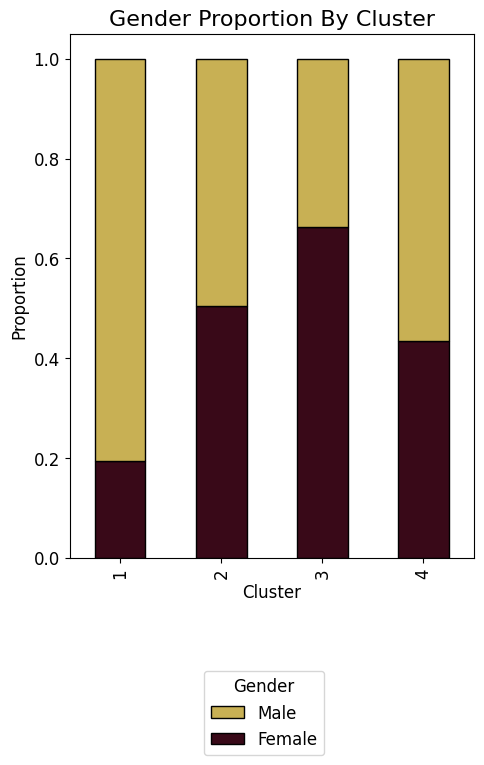

In [ ]:
# Pull gender table into python, then plot
gender_table = pandas2ri.rpy2py(robjects.globalenv['gender_table'])

# Make it a long format DF for plotting
gender_plot = gender_table.melt(
    id_vars = 'cluster',
    value_vars=['genderFemale', 'genderMale'],
    var_name='gender',
    value_name='proportion'
)

# Remove gender from gender names
gender_plot['gender'] = gender_plot['gender'].str.replace('gender', '')

# Actually reorient for stacked bar plot
gender_pivot = gender_plot.pivot_table(
    index='cluster',
    columns='gender',
    values='proportion',
    aggfunc='sum',
)


## Plot
fig, ax = plt.subplots(figsize=(5, 8))

gender_pivot.plot(
    kind='bar',
    stacked=True,
    color=[our_palette[4], our_palette[3]],
    edgecolor='black',
    ax=ax
)

handles, labels = ax.get_legend_handles_labels()
order = [1, 0]

# Now set the legend in correct order
ax.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Gender',
    bbox_to_anchor=(0.65, -0.2)
)

ax.set_title("Gender Proportion By Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
plt.tight_layout()

fig.savefig('outputs/preso/gender.png', dpi=300, bbox_inches='tight')

plt.show()

#### Race

In [ ]:
%%R
# Means
race_table <- svyby(~race, ~cluster, design, svymean, na.rm = TRUE)
race_table

  cluster  raceAsian  raceBlack raceMexican American raceOther Hispanic
1       1 0.04574138 0.08579168           0.10704779         0.06929704
2       2 0.03346941 0.11092543           0.07483329         0.07811883
3       3 0.06221450 0.13480745           0.07190603         0.10808537
4       4 0.07825673 0.09511043           0.08039464         0.07201406
  raceOther or Multi raceWhite se.raceAsian se.raceBlack
1         0.05520309 0.6369190  0.022865288  0.013492669
2         0.04941245 0.6532406  0.005529382  0.012595351
3         0.04280932 0.5801773  0.008083782  0.013626918
4         0.03808827 0.6361359  0.008859978  0.009997376
  se.raceMexican American se.raceOther Hispanic se.raceOther or Multi
1              0.01926856           0.012264053           0.007174996
2              0.01602090           0.011163540           0.004907170
3              0.01171591           0.008742923           0.004601263
4              0.01454518           0.009260766           0.005233961
  se.

In [ ]:
%%R
# Chi square for categorical data
gender_model <- svyglm(race ~ cluster, design, family = 'binomial')
regTermTest(gender_model, 'cluster')
# I don't see any way to do chisq within survey package.
# Binomial is not appropriate for categorical outcome. Don't see a solution here
# Could just use unweighted chisq?

Wald test for cluster
 in svyglm(formula = race ~ cluster, design = design, family = "binomial")
F =  12.01009  on  3  and  37  df: p= 1.2281e-05 


In addition: Warning message:
In eval(family$initialize) : non-integer #successes in a binomial glm!


In [ ]:
# Try unweighted chi square with python
race_cont_table = pd.crosstab(df['gender'], df['cluster'])
# print(cont_table)

chi2, p, dof, expected = chi2_contingency(race_cont_table)

print(f"Chi2: {round(chi2, 3)}")
p_format = f"{p:.3f}"
print(f"P: {p_format}")
print(f"DoF: {dof}")
# Does not account for survey design, but still highly significant

Chi2: 759.869
P: 0.000
DoF: 3


race        Asian     Black  Mexican American  Other Hispanic  Other or Multi  \
cluster                                                                         
1        0.045741  0.085792          0.107048        0.069297        0.055203   
2        0.033469  0.110925          0.074833        0.078119        0.049412   
3        0.062214  0.134807          0.071906        0.108085        0.042809   
4        0.078257  0.095110          0.080395        0.072014        0.038088   

race        White  
cluster            
1        0.636919  
2        0.653241  
3        0.580177  
4        0.636136  


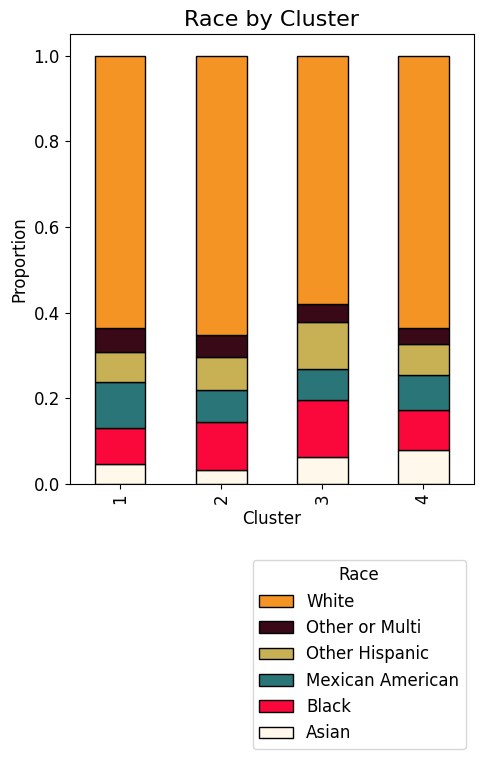

In [ ]:
# Pull race table into python, then plot
race_table = pandas2ri.rpy2py(robjects.globalenv['race_table'])
# print(race_table)

# Make it a long format DF for plotting
race_plot = race_table.melt(
    id_vars = 'cluster',
    value_vars=['raceBlack', 'raceAsian', 'raceMexican American', 'raceOther Hispanic', 'raceOther or Multi', 'raceWhite'],
    var_name='race',
    value_name='proportion'
)

# Remove gender from gender names
race_plot['race'] = race_plot['race'].str.replace('race', '')
# print(race_plot)

pivot_race = race_plot.pivot_table(
    index='cluster',
    columns='race',
    values='proportion',
    aggfunc='sum'
)
print(pivot_race)



## -----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 8))

pivot_race.plot(
    kind='bar',
    stacked=True,
    color=our_palette,
    edgecolor='black',
    ax=ax
)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
order = [5, 4, 3, 2, 1, 0]

# Now set the legend in correct order
ax.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Race',
    bbox_to_anchor=(1, -0.15)
)

ax.set_title("Race by Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
plt.tight_layout()

plt.show()


#### Age

In [ ]:
%%R
# Means
age_table <- svyby(~age, ~cluster, design, svymean)
age_table

  cluster      age        se
1       1 43.43453 0.7003933
2       2 46.04366 0.6033982
3       3 48.91764 0.4736610
4       4 50.11400 0.6841101


In [ ]:
%%R
# Quantiles
svyby(
    formula = ~age,
    by = ~cluster,
    design = design,
    FUN = svyquantile,
    quantiles = c(0, 0.25, 0.5, 0.75, 1),
    na.rm = TRUE
)

  cluster age.0 age.0.25 age.0.5 age.0.75 age.1  se.age.0 se.age.0.25
1       1    18       30      42       56    80 0.4947861   0.7421791
2       2    18       31      44       61    80 0.2473930   0.7421791
3       3    18       33      50       64    80 0.2473930   0.7421791
4       4    18       36      51       63    80 0.4947861   1.2369652
  se.age.0.5 se.age.0.75 se.age.1
1  0.7421791   0.7421791        0
2  1.2369652   0.7421791        0
3  0.9895722   0.7421791        0
4  1.2369652   0.7421791        0


In [ ]:
%%R
# ANOVA
age_model <- svyglm(age ~ cluster, design)
(anovas$age <- regTermTest(age_model, 'cluster'))
# If p < 0.05, suggests differences by cluster

Wald test for cluster
 in svyglm(formula = age ~ cluster, design = design)
F =  36.60674  on  3  and  37  df: p= 3.6436e-11 


In [ ]:
%%R
# Posthoc test
# ANOVA says that there are differences, but not which are different
# Unfortunately no good posthoc test in survey package
# But we can do pairwise t tests with all combinations of clusters
# Then we have to manually correct p-value, because running many tests inflates
# type 1 error.

# Bonferroni is easiest. Just divide alpha level (p value cutoff) by the number
# of tests that you ran. So if we compare every combination of clusters on age,
# that would be 6 tests. Instead of using 0.05 as cutoff, we can just use
# 0.0083.

# Note this is a conservative method (overcorrects). But it is definitely the
# easiest to do manually

# Also note this is a custom function, defined up top

(posthocs$age <- get_posthoc('age', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2    3.155  39   0.003   *
2       1       3    9.387  39   0.000   *
3       1       4    7.293  39   0.000   *
4       2       3    4.422  39   0.000   *
5       2       4    5.205  39   0.000   *
6       3       4    1.686  39   0.100    


   cluster        age        se
1        1  43.434532  0.700393
2        2  46.043661  0.603398
3        3  48.917639  0.473661
4        4  50.114002  0.684110


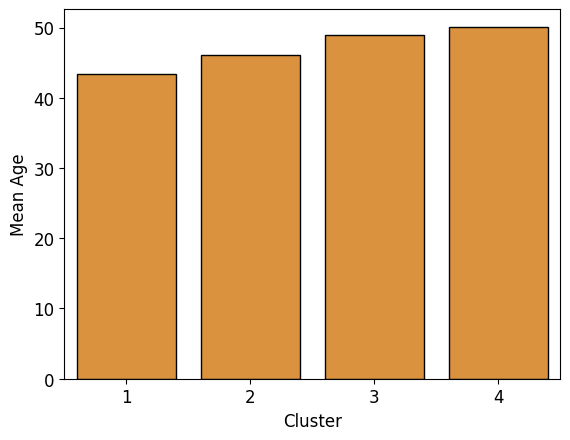

In [ ]:
# Pull age table into python, then plot
age_table = pandas2ri.rpy2py(robjects.globalenv['age_table'])
print(age_table)

sns.barplot(
    data=age_table,
    x='cluster',
    y='age',
    # yerr=age_table['se'],
    color='#f49425',
    edgecolor='black'
)

plt.xlabel("Cluster")
plt.ylabel("Mean Age")
plt.show()




# Actually reorient for stacked bar plot
# age_table = age_table.pivot_table(
#     index='cluster',
#     columns='age',
#     values='proportion',
#     aggfunc='sum',
# )


# ## Plot
# fig, ax = plt.subplots(figsize=(5, 8))

# age_table.plot(
#     kind='bar',
#     stacked=True,
#     color=[our_palette[4], our_palette[3]],
#     edgecolor='black',
#     ax=ax
# )

# handles, labels = ax.get_legend_handles_labels()
# order = [1, 0]

# # Now set the legend in correct order
# ax.legend(
#     [handles[idx] for idx in order],
#     [labels[idx] for idx in order],
#     title='Gender',
#     bbox_to_anchor=(0.65, -0.2)
# )

# ax.set_title("Gender Proportion By Cluster")
# ax.set_xlabel("Cluster")
# ax.set_ylabel("Proportion")
# plt.tight_layout()

# fig.savefig('outputs/preso/gender.png', dpi=300, bbox_inches='tight')

# plt.show()


#### Income

In [ ]:
%%R
# Means
income_table <- svyby(~income_ratio, ~cluster, design, svymean)
income_table

  cluster income_ratio         se
1       1     3.107612 0.10671781
2       2     2.982891 0.06054728
3       3     2.881033 0.06230181
4       4     3.566905 0.06064719


In [ ]:
%%R
# Quantiles
svyby(
    formula = ~income_ratio,
    by = ~cluster,
    design = design,
    FUN = svyquantile,
    quantiles = c(0, 0.25, 0.5, 0.75, 1),
    na.rm = TRUE
)

  cluster income_ratio.0 income_ratio.0.25 income_ratio.0.5 income_ratio.0.75
1       1   5.397605e-79              1.74             3.16              5.00
2       2   5.397605e-79              1.58             3.02              4.86
3       3   5.397605e-79              1.34             2.79              4.94
4       4   5.397605e-79              2.31             4.12              5.00
  income_ratio.1 se.income_ratio.0 se.income_ratio.0.25 se.income_ratio.0.5
1              5       0.064322192           0.14843583           0.2201798
2              5       0.012369652           0.08411364           0.1138008
3              5       0.009895722           0.05195254           0.1162747
4              5       0.024739305           0.11380080           0.1335922
  se.income_ratio.0.75 se.income_ratio.1
1           0.00000000                 0
2           0.08658757                 0
3           0.10143115                 0
4           0.00000000                 0


In [ ]:
%%R
# ANOVA
income_model <- svyglm(income_ratio ~ cluster, design)
(anovas$income <- regTermTest(income_model, 'cluster'))
# If p < 0.05, suggests differences by cluster

Wald test for cluster
 in svyglm(formula = income_ratio ~ cluster, design = design)
F =  38.07908  on  3  and  37  df: p= 2.1153e-11 


In [ ]:
%%R
# Posthoc test
(posthocs$income <- get_posthoc('income_ratio', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -1.235  39   0.224    
2       1       3   -2.550  39   0.015    
3       1       4    5.534  39   0.000   *
4       2       3   -1.672  39   0.103    
5       2       4    8.551  39   0.000   *
6       3       4    9.802  39   0.000   *


   cluster  income_ratio        se
1        1      3.107612  0.106718
2        2      2.982891  0.060547
3        3      2.881033  0.062302
4        4      3.566905  0.060647


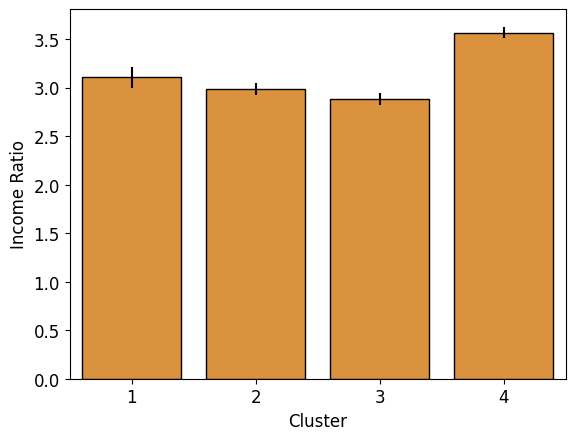

In [ ]:
# Plot income
income_table = pandas2ri.rpy2py(robjects.globalenv['income_table'])
print(income_table)

sns.barplot(
    data=income_table,
    x='cluster',
    y='income_ratio',
    yerr=income_table['se'],
    color='#f49425',
    edgecolor='black'
)

plt.xlabel("Cluster")
plt.ylabel("Income Ratio")
plt.show()

### Education

In [ ]:
%%R
# Means
ed_table <- svyby(~education, ~cluster, design, svymean, na.rm = TRUE)

# Remove SEs for clarity
ed_table <- ed_table %>%
  select(-starts_with('se')) %>%
  mutate(across(where(is.numeric), ~ round(.x, 6)))
ed_table

  cluster education9th to 11th grade educationCollege graduate or above
1       1                   0.056412                           0.301512
2       2                   0.060392                           0.313530
3       3                   0.068697                           0.297120
4       4                   0.047506                           0.500735
  educationDon't know educationHigh school/GED educationLess than 9th grade
1            0.032267                 0.247974                     0.020012
2            0.039354                 0.249016                     0.022023
3            0.039182                 0.277205                     0.036091
4            0.012732                 0.174281                     0.021935
  educationSome college or AA
1                    0.341824
2                    0.315685
3                    0.281704
4                    0.242810


In [ ]:
# Using unweighted ChiSq with Python
# Because no Chisq options in R survey package.
# Note that this does not take into account survey design.
# Don't see other options to do this though
ed_cont_table = pd.crosstab(df['education'], df['cluster'])
# print(cont_table)

chi2, p, dof, expected = chi2_contingency(ed_cont_table)

print(f"Chi2: {round(chi2, 3)}")
p_format = f"{p:.3f}"
print(f"P: {p_format}")
print(f"DoF: {dof}")

Chi2: 389.759
P: 0.000
DoF: 15


Index(['education9th to 11th grade', 'educationCollege graduate or above',
       'educationDon't know', 'educationHigh school/GED',
       'educationLess than 9th grade', 'educationSome college or AA'],
      dtype='object')
    cluster                           education  proportion
0         1          education9th to 11th grade    0.056412
1         2          education9th to 11th grade    0.060392
2         3          education9th to 11th grade    0.068697
3         4          education9th to 11th grade    0.047506
4         1  educationCollege graduate or above    0.301512
5         2  educationCollege graduate or above    0.313530
6         3  educationCollege graduate or above    0.297120
7         4  educationCollege graduate or above    0.500735
8         1                 educationDon't know    0.032267
9         2                 educationDon't know    0.039354
10        3                 educationDon't know    0.039182
11        4                 educationDon't know    0.0

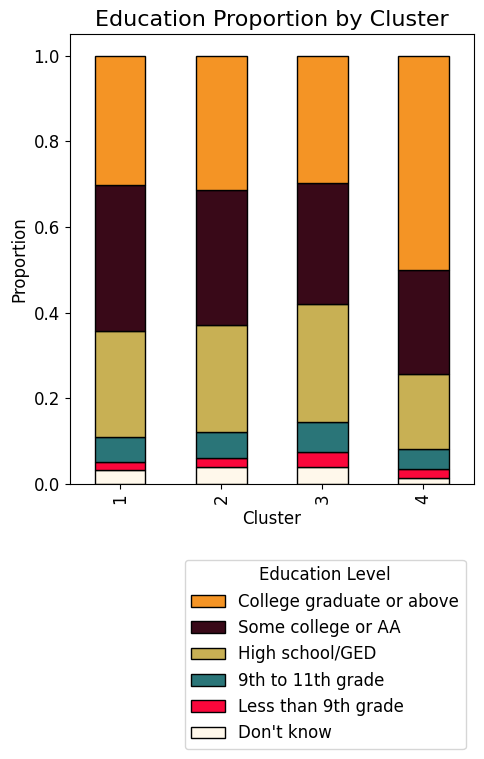

In [ ]:
# Plot education
ed_table = pandas2ri.rpy2py(robjects.globalenv['ed_table'])
# print(ed_table)

# Make it a long format DF for plotting
value_vars = ed_table.filter(regex='^education').columns
print(value_vars)
ed_plot = ed_table.melt(
    id_vars = 'cluster',
    value_vars=value_vars,
    var_name='education',
    value_name='proportion'
)
print(ed_plot)

# Remove gender from gender names
ed_plot['education'] = ed_plot['education'].str.replace('education', '')

#
pivot_ed = ed_plot.pivot_table(
    index='cluster',
    columns='education',
    values='proportion',
    aggfunc='sum'
)
hue_order=[
    "Don't know",
    'Less than 9th grade',
    '9th to 11th grade',
    'High school/GED',
    'Some college or AA',
    'College graduate or above'
]
pivot_ed = pivot_ed[hue_order]
# print(pivot_ed)


fig, ax = plt.subplots(figsize=(5, 8))

pivot_ed.plot(
    kind='bar',
    stacked=True,
    color=our_palette,
    edgecolor='black',
    ax=ax
)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
order = [5, 4, 3, 2, 1, 0]

# Now set the legend in correct order
ax.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Education Level',
    bbox_to_anchor=(1, -0.15)
)

ax.set_title("Education Proportion by Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
plt.tight_layout()

fig.savefig('outputs/preso/education.png', dpi=300, bbox_inches='tight')
plt.show()

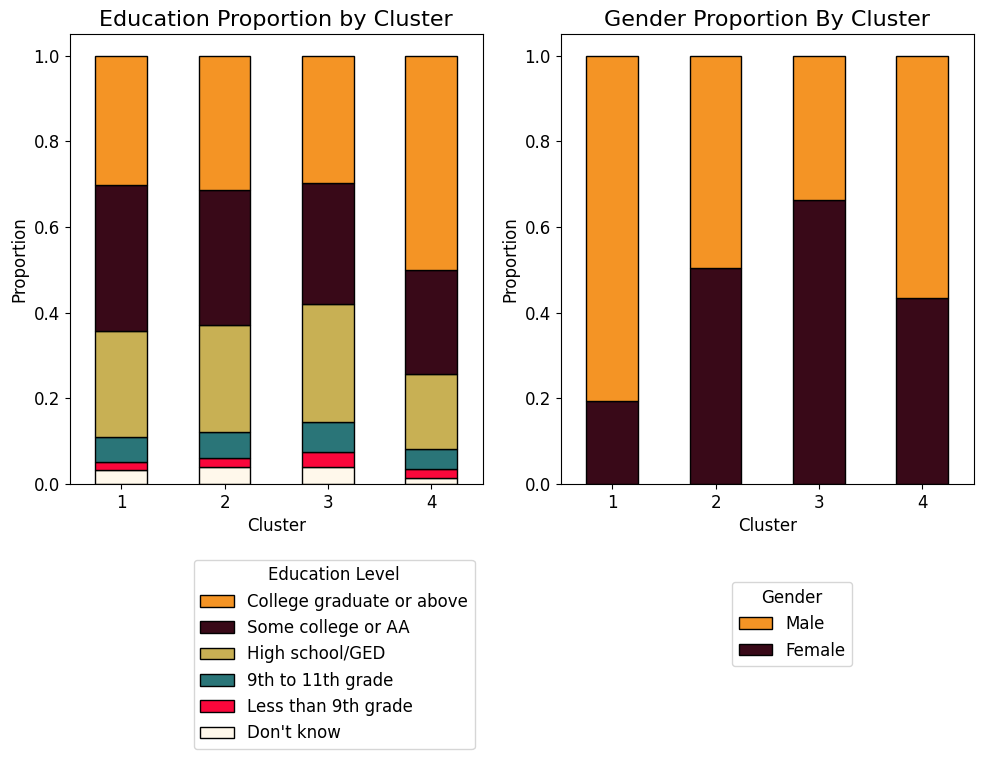

In [ ]:
# Try combining the gender and education plots
fig, ax = plt.subplots(figsize=(10, 8), nrows=1, ncols=2)


## Education plot
pivot_ed.plot(
    kind='bar',
    stacked=True,
    color=our_palette,
    edgecolor='black',
    ax=ax[0]
)

handles, labels = ax[0].get_legend_handles_labels()
order = [5, 4, 3, 2, 1, 0]
ax[0].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Education Level',
    bbox_to_anchor=(1, -0.15)
)

ax[0].set_title("Education Proportion by Cluster")
ax[0].set_xlabel("Cluster")
ax[0].set_ylabel("Proportion")
ax[0].tick_params(axis='x', labelrotation=0)

## Gender plot
gender_pivot.plot(
    kind='bar',
    stacked=True,
    color=[our_palette[4], our_palette[5]],
    edgecolor='black',
    ax=ax[1]
)

handles, labels = ax[1].get_legend_handles_labels()
order = [1, 0]

ax[1].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Gender',
    bbox_to_anchor=(0.725, -0.2)
)

ax[1].set_title("Gender Proportion By Cluster")
ax[1].set_xlabel("Cluster")
ax[1].set_ylabel("Proportion")
ax[1].tick_params(axis='x', labelrotation=0)


plt.tight_layout()
fig.savefig('outputs/preso/education_and_gender.png', dpi=300, bbox_inches='tight')
plt.show()

### Monster Figure

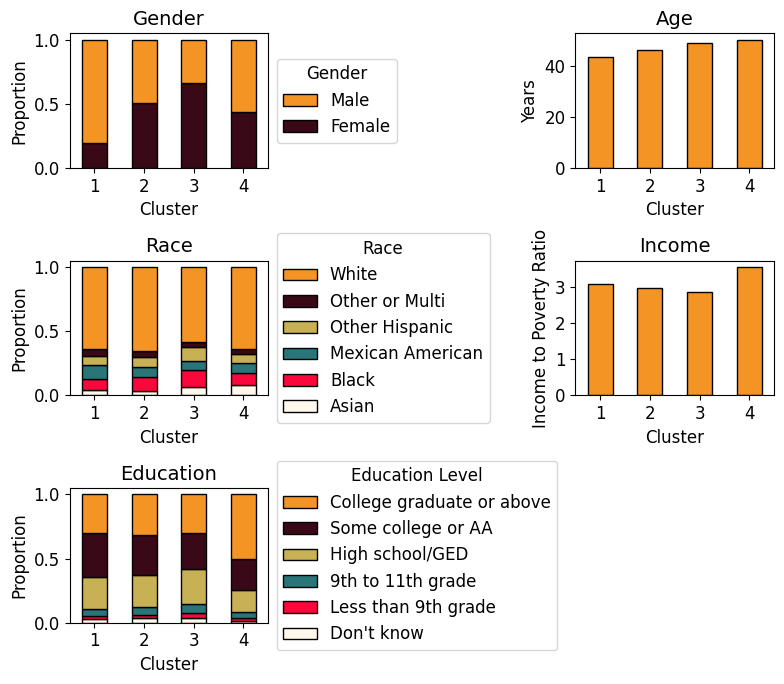

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(8, 7))
axs = axs.flatten()


## Age --------------------------------------
axs[1].set_title('Age', fontsize = 14)
age_table.plot(
    kind='bar',
    x='cluster',
    y='age',
    color=our_palette[5],
    edgecolor='black',
    ax=axs[1]
)
axs[1].legend().set_visible(False)


## Gender -----------------------------------------
axs[0].set_title('Gender', fontsize = 14)
gender_pivot.plot(
    kind='bar',
    stacked=True,
    color=[our_palette[4], our_palette[5]],
    edgecolor='black',
    ax=axs[0]
)
handles, labels = axs[0].get_legend_handles_labels()
order = [1, 0]
axs[0].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Gender',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)


## Race ----------------------------------------
axs[2].set_title('Race', fontsize = 14)
pivot_race.plot(
    kind='bar',
    stacked=True,
    color=our_palette,
    edgecolor='black',
    ax=axs[2]
)
handles, labels = axs[2].get_legend_handles_labels()
order = [5, 4, 3, 2, 1, 0]
axs[2].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Race',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)


## Income -----------------------------------
axs[3].set_title('Income', fontsize = 14)
income_table.plot(
    kind='bar',
    x='cluster',
    y='income_ratio',
    color=our_palette[5],
    edgecolor='black',
    ax=axs[3]
)
axs[3].legend().set_visible(False)


## Education ----------------------------------
hue_order=[
    "Don't know",
    'Less than 9th grade',
    '9th to 11th grade',
    'High school/GED',
    'Some college or AA',
    'College graduate or above'
]
pivot_ed = pivot_ed[hue_order]
axs[4].set_title('Education', fontsize = 14)
pivot_ed.plot(
    kind='bar',
    stacked=True,
    color=our_palette,
    edgecolor='black',
    ax=axs[4]
)
handles, labels = axs[4].get_legend_handles_labels()
order = [5, 4, 3, 2, 1, 0]
axs[4].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    title='Education Level',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

# Remove last plot
axs[5].axis('off')

## Plot ---------------------------------------------
y_labels = ['Proportion', 'Years', 'Proportion', 'Income to Poverty Ratio', 'Proportion']
for ax, y_label in zip(axs, y_labels):
    ax.set_ylabel(y_label, fontsize=12)

for ax in axs:
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('Cluster', fontsize=12)

plt.tight_layout()
fig.savefig('outputs/paper/demo_monster.png', dpi=300, bbox_inches='tight')
plt.show()


## Biomarkers



### GLM Example

Can do linear, logistic, poisson, etc., and include covariates here. Estimate effect of cluster while holding demographics constant.

Alternatively, we could put clusters in as the dependent variable and see how well our other variables predict cluster assignment.

Just using the example of blood mercury here because it doesn't make much sense to do it on demographics.

In [ ]:
%%R
blood_merc_1 <- svyglm(blood_mercury ~ cluster + age + education + race + gender, design)
print(summary(blood_merc_1))


Call:
svyglm(formula = blood_mercury ~ cluster + age + education + 
    race + gender, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         1.033976   0.230629   4.483 0.000142 ***
cluster2                           -0.113068   0.083223  -1.359 0.186403    
cluster3                            0.129646   0.078305   1.656 0.110292    
cluster4                            0.343923   0.070027   4.911 4.69e-05 ***
age                                 0.010855   0.001439   7.544 6.74e-08 ***
educationCollege graduate or above  0.775589   0.084816   9.144 1.89e-09 ***
educationDon't know                 0.260847   0.110440   2.362 0.026279 *  
educationHigh school/GED            0.073462   0.067268   1.092 0.285213    
educationLess than 9th grade        0.372882   0.169081   2.205 0.036848 *  
edu

Can compared nested models with anova()

In [ ]:
%%R
# Run another model with income, then compare
blood_merc_2 <- svyglm(
    blood_mercury ~ cluster + age + education + race + gender + income_ratio,
    design
)

# Compare with anova
print(anova(blood_merc_1, blood_merc_2))
# model2 is better

Working (Rao-Scott+F) LRT for income_ratio
 in svyglm(formula = blood_mercury ~ cluster + age + education + 
    race + gender + income_ratio, design = design)
Working 2logLR =  46.27934 p= 5.4204e-07 
df=1;  denominator df= 24


Significant result suggests more complex model is preferred

Print confidence intervals:

In [ ]:
%%R
print(confint(blood_merc_2))

                                         2.5 %      97.5 %
(Intercept)                         0.40140291  1.37336405
cluster2                           -0.27724011  0.06414279
cluster3                           -0.02646206  0.29792013
cluster4                            0.17649207  0.47002272
age                                 0.00698332  0.01290023
educationCollege graduate or above  0.40265711  0.72971401
educationDon't know                -0.02409931  0.38005429
educationHigh school/GED           -0.11107551  0.13791965
educationLess than 9th grade        0.05368447  0.73752326
educationSome college or AA         0.05358520  0.27973887
raceBlack                          -1.17275332 -0.32748534
raceMexican American               -1.37678777 -0.42776497
raceOther Hispanic                 -1.21020576 -0.31164746
raceOther or Multi                 -1.27328677 -0.33709057
raceWhite                          -1.47822369 -0.57332431
genderMale                          0.04284966  0.216356

Get R2 of model using custom function defined in the setup:

In [ ]:
%%R
get_r2(blood_merc_2, 'blood_mercury', design = design)

              variance     SE
blood_mercury 0.081156 0.3321


Model accounts for that proportion of the variance in blood mercury

Testing out predictive marginal means. These are model-based estimates of what blood mercury would be, not based on raw data.

Want to run a model with everything we are interested in EXCEPT the clusters. Then use svypredmeans(model, ~cluster) to get marginal means by cluster.

In [ ]:
%%R
blood_merc_3 <- svyglm(
    blood_mercury ~ age + education + race + gender + income_ratio,
    design
)
svypredmeans(blood_merc_3, ~cluster)

     mean     SE
2 0.99315 0.0537
1 1.09970 0.0852
4 1.42296 0.0646
3 1.23543 0.0559


### Analysis

In [ ]:
%%R
# GLMs : Mercury ~ Cluster
merc_glm <- svyglm(blood_mercury ~ cluster, design)
print(summary(merc_glm))


Call:
svyglm(formula = blood_mercury ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.06736    0.08228  12.972 2.45e-15 ***
cluster2    -0.13740    0.08064  -1.704   0.0968 .  
cluster3     0.13605    0.06940   1.960   0.0575 .  
cluster4     0.52656    0.07335   7.179 1.64e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 3.066165)

Number of Fisher Scoring iterations: 2



In [ ]:
%%R
# Adding ANOVA here - test whether there are differences among clusters
(anovas$mercury <- regTermTest(merc_glm, 'cluster'))

Wald test for cluster
 in svyglm(formula = blood_mercury ~ cluster, design = design)
F =  28.02441  on  3  and  37  df: p= 1.2464e-09 


In [ ]:
%%R
# Adding post-hoc tests - which clusters are different from one another
(posthocs$mercury <- get_posthoc('blood_mercury', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -1.704  39   0.096    
2       1       3    1.960  39   0.057    
3       1       4    7.179  39   0.000   *
4       2       3    4.425  39   0.000   *
5       2       4    8.153  39   0.000   *
6       3       4    5.423  39   0.000   *


In [ ]:
%%R
#GLMs total_cholesterol ~ clusters
tot_chol_glm <- svyglm(total_cholesterol ~ cluster, design)
print(summary(tot_chol_glm))


Call:
svyglm(formula = total_cholesterol ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  183.438      1.556 117.879   <2e-16 ***
cluster2       3.615      1.682   2.149   0.0383 *  
cluster3       4.929      1.850   2.664   0.0114 *  
cluster4       4.431      1.746   2.538   0.0155 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1729.095)

Number of Fisher Scoring iterations: 2



In [ ]:
%%R
# Adding ANOVA here - test whether there are differences among clusters
(anovas$total_cholesterol <- regTermTest(tot_chol_glm, 'cluster'))

Wald test for cluster
 in svyglm(formula = total_cholesterol ~ cluster, design = design)
F =  3.036901  on  3  and  37  df: p= 0.04109 


In [ ]:
%%R
# post-hoc tests - which clusters are different from one another
(posthocs$cholesterol <- get_posthoc('total_cholesterol', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2    2.149  39   0.038    
2       1       3    2.664  39   0.011    
3       1       4    2.538  39   0.015    
4       2       3    1.250  39   0.219    
5       2       4    0.586  39   0.561    
6       3       4   -0.298  39   0.767    


In [ ]:
%%R
#GLMs avg_systolic_bp ~ clusters
avg_systolic_bp_glm <- svyglm(avg_systolic_bp ~ cluster, design)
print(summary(avg_systolic_bp_glm))


Call:
svyglm(formula = avg_systolic_bp ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 121.4829     0.5569 218.138  < 2e-16 ***
cluster2     -2.1839     0.7149  -3.055  0.00416 ** 
cluster3     -0.4286     0.6939  -0.618  0.54057    
cluster4     -0.2420     0.5919  -0.409  0.68506    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 290.0994)

Number of Fisher Scoring iterations: 2



In [ ]:
%%R
# Adding ANOVA here - test whether there are differences among clusters
(anovas$systolic <- regTermTest(avg_systolic_bp_glm, 'cluster'))

Wald test for cluster
 in svyglm(formula = avg_systolic_bp ~ cluster, design = design)
F =  3.961244  on  3  and  37  df: p= 0.015174 


In [ ]:
%%R
#  post-hoc tests - which clusters are different from one another
(posthocs$systolic <- get_posthoc('avg_systolic_bp', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -3.055  39   0.004   *
2       1       3   -0.618  39   0.540    
3       1       4   -0.409  39   0.685    
4       2       3    2.562  39   0.014    
5       2       4    3.098  39   0.004   *
6       3       4    0.348  39   0.730    


In [ ]:
%%R
#GLMs avg_diastolic_bp ~ clusters
avg_diastolic_bp_glm <- svyglm(avg_diastolic_bp ~ cluster, design)
print(summary(avg_diastolic_bp_glm))


Call:
svyglm(formula = avg_diastolic_bp ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  74.7798     0.4527 165.168  < 2e-16 ***
cluster2     -1.4416     0.4603  -3.132  0.00339 ** 
cluster3     -0.8112     0.5619  -1.444  0.15728    
cluster4     -1.4934     0.4870  -3.067  0.00403 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 116.2808)

Number of Fisher Scoring iterations: 2



In [ ]:
%%R
# Adding ANOVA here - test whether there are differences among clusters
(anovas$diastolic <- regTermTest(avg_diastolic_bp_glm, 'cluster'))

Wald test for cluster
 in svyglm(formula = avg_diastolic_bp ~ cluster, design = design)
F =  6.530416  on  3  and  37  df: p= 0.0011747 


In [ ]:
%%R
# Adding post-hoc tests - which clusters are different from one another
(posthocs$diastolic <- get_posthoc('avg_diastolic_bp', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -3.132  39   0.003   *
2       1       3   -1.444  39   0.157    
3       1       4   -3.067  39   0.004   *
4       2       3    1.651  39   0.107    
5       2       4   -0.135  39   0.893    
6       3       4   -2.153  39   0.038    


In [ ]:
%%R
# Make a biomarker averages table
library(dplyr)
library(tidyr)


bm_cluster_means <- dat %>%
  group_by(cluster) %>%
  summarise(
    avg_total_cholesterol = mean(total_cholesterol, na.rm = TRUE),
    avg_systolic_bp = mean(avg_systolic_bp, na.rm = TRUE),
    avg_diastolic_bp = mean(avg_diastolic_bp, na.rm = TRUE),
    avg_blood_mercury =mean(blood_mercury, na.rm=TRUE))
  head(bm_cluster_means)




# A tibble: 4 × 5
  cluster avg_total_cholesterol avg_systolic_bp avg_diastolic_bp
  <fct>                   <dbl>           <dbl>            <dbl>
1 1                        182.            123.             75.0
2 2                        185.            122.             73.9
3 3                        187.            124.             74.6
4 4                        187.            124.             73.9
# ℹ 1 more variable: avg_blood_mercury <dbl>


In [ ]:
%%R
# lets see how weights effect it
# Load necessary library
library(dplyr)

# Calculate weighted means by cluster for biomarkers
bm_cluster_means_weighted <- dat %>%
  group_by(cluster) %>%
  summarize(
    weighted_avg_total_cholesterol = weighted.mean(total_cholesterol, w = weight_2d),
    weighted_avg_blood_mercury = weighted.mean(blood_mercury, w = weight_2d),
    weighted_avg_systolic_bp = weighted.mean(avg_systolic_bp, w = weight_2d),
    weighted_avg_diastolic_bp = weighted.mean(avg_diastolic_bp, w = weight_2d)
  )

# View the results
#head(bm_cluster_means_weighted)


In [ ]:
%%R
# make weighted cluster means long

bm_cluster_means_weighted_long <- bm_cluster_means_weighted %>%
  pivot_longer(cols = c(weighted_avg_total_cholesterol, weighted_avg_systolic_bp, weighted_avg_diastolic_bp, weighted_avg_blood_mercury),
               names_to = "Biomarker",
               values_to = "Average Value")


In [ ]:
bm_cluster_means_weighted = pandas2ri.rpy2py(robjects.globalenv['bm_cluster_means_weighted'])
bm_cluster_means_weighted.head()
bm_cluster_means_weighted_long = pandas2ri.rpy2py(robjects.globalenv['bm_cluster_means_weighted_long'])
bm_cluster_means_weighted_long.head(20)

,cluster,Biomarker,Average Value
1,1,weighted_avg_total_cholesterol,183.437915
2,1,weighted_avg_systolic_bp,121.482929
3,1,weighted_avg_diastolic_bp,74.779839
4,1,weighted_avg_blood_mercury,1.067358
5,2,weighted_avg_total_cholesterol,187.052455
6,2,weighted_avg_systolic_bp,119.298994
7,2,weighted_avg_diastolic_bp,73.338263
8,2,weighted_avg_blood_mercury,0.929958
9,3,weighted_avg_total_cholesterol,188.366984
10,3,weighted_avg_systolic_bp,121.054336


In [ ]:
%%R
#make into long format for plotting
cluster_means_long <- bm_cluster_means %>%
  pivot_longer(cols = c(avg_total_cholesterol, avg_systolic_bp, avg_diastolic_bp, avg_blood_mercury),
               names_to = "Biomarker",
               values_to = "Average Value")


In [ ]:
# pull bm_cluster_means robject into python
bm_cluster_means = pandas2ri.rpy2py(robjects.globalenv['cluster_means_long'])
bm_cluster_means.head()

,cluster,Biomarker,Average Value
1,1,avg_total_cholesterol,181.964789
2,1,avg_systolic_bp,123.195129
3,1,avg_diastolic_bp,74.957160
4,1,avg_blood_mercury,1.081030
5,2,avg_total_cholesterol,185.494624


    cluster              Biomarker  Average Value
1         1  avg_total_cholesterol     181.964789
2         1        avg_systolic_bp     123.195129
3         1       avg_diastolic_bp      74.957160
5         2  avg_total_cholesterol     185.494624
6         2        avg_systolic_bp     122.267281
7         2       avg_diastolic_bp      73.935484
9         3  avg_total_cholesterol     186.622133
10        3        avg_systolic_bp     124.099264
11        3       avg_diastolic_bp      74.604609
13        4  avg_total_cholesterol     186.558170
14        4        avg_systolic_bp     123.681627
15        4       avg_diastolic_bp      73.886420


<ipython-input-60-9e55fc175815>:13: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(


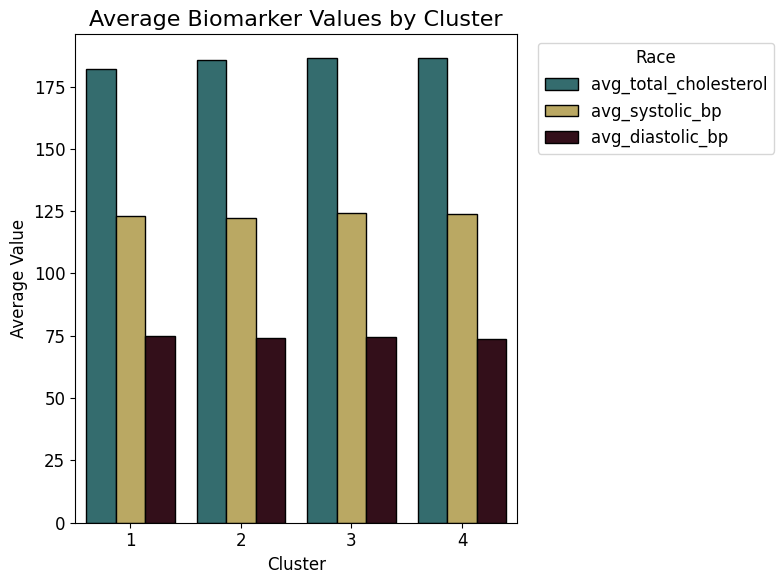

In [ ]:
#Biomarker ~ Cluster Visualization

#mercury to be graphed alone, too small
bm_cluster_means_filtered = bm_cluster_means[bm_cluster_means['Biomarker'] != 'avg_blood_mercury']

# Check the filtered data
print(bm_cluster_means_filtered)

# Set up the plot
plt.figure(figsize=(10, 6))

# Create the bar plot with our color palette
sns.barplot(
    x='cluster',
    y='Average Value',
    hue='Biomarker',
    data=bm_cluster_means_filtered,
    palette=our_palette[2:6],
    edgecolor='black'
)

plt.legend(
    title="Race",
    bbox_to_anchor=(1.6, 1),
    loc='upper right'
)
plt.title('Average Biomarker Values by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.tight_layout()

plt.savefig('outputs/preso/bm_cluster_means.png', format='png', dpi=300)
# Show the plot
plt.show()


<ipython-input-61-86ad55f1ca24>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-61-86ad55f1ca24>:11: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


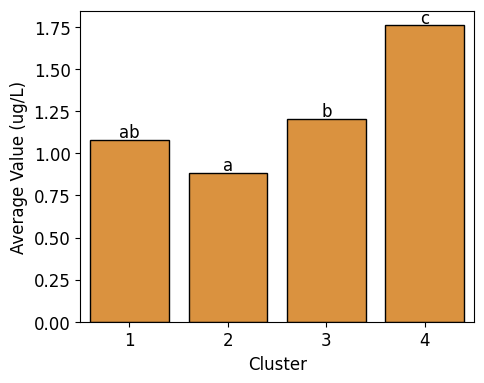

In [ ]:
#Mercury Visualization
bm_cluster_means_merc = bm_cluster_means[bm_cluster_means['Biomarker'] == 'avg_blood_mercury']
bm_cluster_means_merc.head()

# Set up the plot
#plt.figure(figsize=(10, 6))

fig, ax = plt.subplots(figsize=(5, 4))

# Create the bar plot with our palette
sns.barplot(
    x='cluster',
    y='Average Value',
    #hue='Biomarker',
    data=bm_cluster_means_merc,
    palette=our_palette[5:6],
    edgecolor='black'
)

# Add CLD letters of significance
letters = ['ab', 'a', 'b', 'c']
for i, (cluster, value) in enumerate(zip(bm_cluster_means_merc['cluster'], bm_cluster_means_merc['Average Value'])):
    ax.text(i, value + -0.01, letters[i], ha='center', va='bottom', color='black')

# ax.set_title('Average Blood Mercury Values by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Value (ug/L)')

plt.tight_layout()

plt.savefig('outputs/paper/mercury_cluster_means.png', format='png', dpi=300)
plt.show()

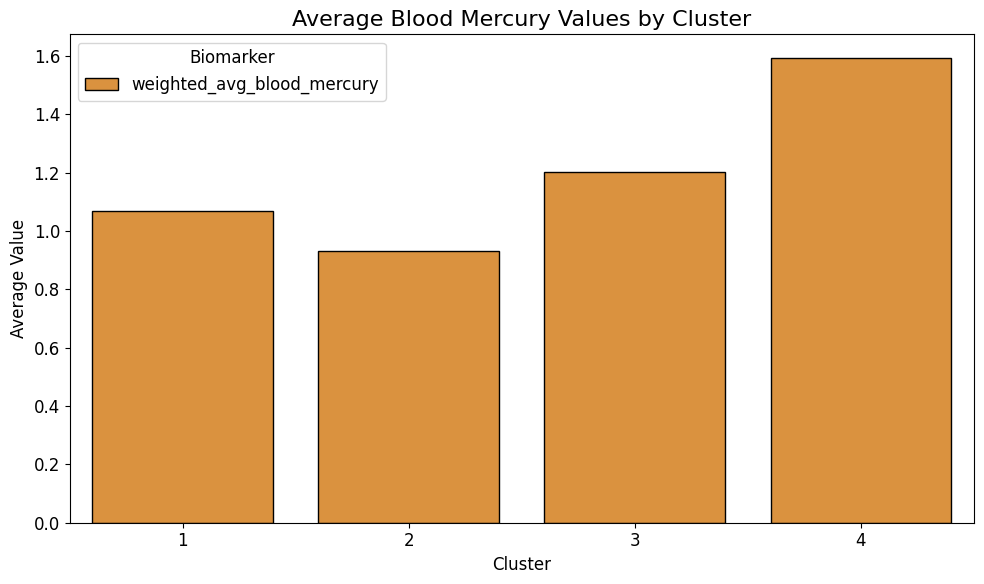

In [ ]:
#weighted Mercury
#Mercury Visualization
bm_cluster_means_weighted_merc = bm_cluster_means_weighted_long[bm_cluster_means_weighted_long['Biomarker'] == 'weighted_avg_blood_mercury']
bm_cluster_means_weighted_merc.head()

# Set up the plot
plt.figure(figsize=(10, 6))

# Create the bar plot with our palette
sns.barplot(
    x='cluster',
    y='Average Value',
    hue='Biomarker',
    data=bm_cluster_means_weighted_merc,
    palette=our_palette[5:6],
    edgecolor='black'
)

# Customize the plot
plt.title('Average Blood Mercury Values by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.tight_layout()

# plt.savefig('outputs/paper/mercury_cluster_means.png', format='png', dpi=300)
# Show the plot
plt.show()

In [ ]:
# pivot_df.head()
# Melt it
#bm_cluster_means_long = pd.melt(bm_cluster_means, id_vars=['cluster'],
#                  var_name='Biomarker',
#                  value_name='Average  Value')

#bm_cluster_means_long.head(20)

#pbp_bm_cluster_means= pd.merge(pivot_df, bm_cluster_means, on='cluster')

#pbp_bm_cluster_means.head()


In [ ]:

# pbp_bm_cluster_means.head(20)




In [ ]:
%%R
print(svyby(~blood_mercury, ~cluster, design, svymean, na.rm = TRUE))
print(svyby(~total_cholesterol, ~cluster, design, svymean, na.rm = TRUE))
print(svyby(~avg_systolic_bp, ~cluster, design, svymean, na.rm = TRUE))
print(svyby(~avg_diastolic_bp, ~cluster, design, svymean, na.rm = TRUE))

  cluster blood_mercury         se
1       1     1.0673578 0.08228240
2       2     0.9299578 0.04815587
3       3     1.2034090 0.05154045
4       4     1.5939173 0.07852490
  cluster total_cholesterol       se
1       1          183.4379 1.556159
2       2          187.0525 1.019283
3       3          188.3670 1.237873
4       4          187.8692 1.335252
  cluster avg_systolic_bp        se
1       1        121.4829 0.5569094
2       2        119.2990 0.4889269
3       3        121.0543 0.4440863
4       4        121.2410 0.4236625
  cluster avg_diastolic_bp        se
1       1         74.77984 0.4527494
2       2         73.33826 0.2653181
3       3         73.96865 0.2865125
4       4         73.28646 0.2780491


In [15]:
%%R
print(head(dat$blood_mercury))
print(svyby(~blood_mercury, ~cluster, design, svyquantile, c(0, 0.25, 0.5, 0.75)))

# print(svyby(~blood_mercury, ~cluster, design, svymean))
# print(svyby(~blood_mercury, ~cluster, design, svyvar))

[1] 0.36 0.42 0.51 0.20 0.31 0.54
  cluster blood_mercury.0 blood_mercury.0.25 blood_mercury.0.5
1       1            0.12               0.21              0.58
2       2            0.12               0.20              0.51
3       3            0.12               0.24              0.60
4       4            0.12               0.38              0.89
  blood_mercury.0.75 se.blood_mercury.0 se.blood_mercury.0.25
1               1.20         0.01979144           0.022265374
2               1.09         0.01979144           0.009895722
3               1.40         0.01979144           0.019791444
4               1.96         0.01979144           0.017317513
  se.blood_mercury.0.5 se.blood_mercury.0.75
1           0.04205682            0.10637901
2           0.02968717            0.05442647
3           0.03463503            0.06927005
4           0.06184826            0.12864438


In [32]:
%%R
# print(svyby(~avg_diastolic_bp, ~cluster, design, svymean))
# print(svyby(~avg_diastolic_bp, ~cluster, design, svyvar))

# print(svyby(~avg_diastolic_bp, ~cluster, design, svyquantile, c(0, 0.25, 0.5, 0.75)))


  cluster avg_diastolic_bp.0 avg_diastolic_bp.0.25 avg_diastolic_bp.0.5
1       1           41.00000              66.66667             74.33333
2       2           34.00000              66.00000             72.66667
3       3           37.33333              66.00000             73.00000
4       4           46.33333              66.33333             73.00000
  avg_diastolic_bp.0.75 se.avg_diastolic_bp.0 se.avg_diastolic_bp.0.25
1              82.00000                   NaN                0.6597148
2              80.00000                   NaN                0.3298574
3              80.66667                   NaN                0.4123217
4              79.33333             0.3298574                0.5772504
  se.avg_diastolic_bp.0.5 se.avg_diastolic_bp.0.75
1               0.5772504                0.6597148
2               0.3298574                0.3298574
3               0.2473930                0.4123217
4               0.3298574                0.4123217


## PBP Consumption Analysis

In [ ]:
%%R

# Run each svyby call and store the results
total_protein <- svyby(~total_protein_density, ~cluster, design, svymean, na.rm = TRUE)
legumes       <- svyby(~pf_legumes_density, ~cluster, design, svymean, na.rm = TRUE)
soy           <- svyby(~pf_soy_density, ~cluster, design, svymean, na.rm = TRUE)
nuts_seeds    <- svyby(~pf_nutsds_density, ~cluster, design, svymean, na.rm = TRUE)

# Extract the means from each dataset (you can select the columns you need)
total_protein_mean <- total_protein %>% select(cluster, total_protein_density)
legumes_mean       <- legumes %>% select(cluster, pf_legumes_density)
soy_mean           <- soy %>% select(cluster, pf_soy_density)
nuts_seeds_mean    <- nuts_seeds %>% select(cluster, pf_nutsds_density)

# Combine the means into a single data frame
protein_means <- total_protein_mean %>%
  left_join(legumes_mean, by = "cluster") %>%
  left_join(soy_mean, by = "cluster") %>%
  left_join(nuts_seeds_mean, by = "cluster")

# Calculate animal protein (subtract plant-based proteins from total protein)
protein_means <- protein_means %>%
  mutate(animal_protein = total_protein_density - pf_legumes_density - pf_soy_density - pf_nutsds_density)

# Prepare the data for stacking (including animal protein)
stacked_protein <- protein_means %>%
  select(cluster, animal_protein, pf_legumes_density, pf_soy_density, pf_nutsds_density) %>%
  rename(Animal = animal_protein,
         Legumes = pf_legumes_density,
         Soy = pf_soy_density,
         Nuts_Seeds = pf_nutsds_density) %>%
  pivot_longer(cols = -cluster, names_to = "Protein_Type", values_to = "Density (oz-eq/1000 kcal)")



In [ ]:
# Goal here is to determine what the average total protein density is per cluster
# Then to see if there is a significant difference between clusters

In [ ]:
%%R

# Solve for proportion of protein consumption is plant-based for each cluster

prop_plant_protein <- protein_means %>%
  mutate(
    prop_legumes = pf_legumes_density / total_protein_density,
    prop_soy = pf_soy_density / total_protein_density,
    prop_nuts_seeds = pf_nutsds_density / total_protein_density,
    prop_plant = (pf_legumes_density + pf_soy_density + pf_nutsds_density) / total_protein_density

  )

print(prop_plant_protein)

  cluster total_protein_density pf_legumes_density pf_soy_density
1       1              2.840013          0.1845334     0.03668705
2       2              2.640894          0.1657639     0.02883789
3       3              3.514876          0.2469083     0.05514342
4       4              4.074080          0.3049553     0.07065294
  pf_nutsds_density animal_protein prop_legumes   prop_soy prop_nuts_seeds
1         0.3558138       2.262978   0.06497627 0.01291792      0.12528600
2         0.2501194       2.196173   0.06276809 0.01091975      0.09471012
3         0.3147954       2.898029   0.07024667 0.01568858      0.08956089
4         0.7706212       2.927851   0.07485256 0.01734206      0.18915217
  prop_plant
1  0.2031802
2  0.1683980
3  0.1754961
4  0.2813468


    cluster Protein_Type  Density (oz-eq/1000 kcal)
1         1       Animal                   2.262978
2         1      Legumes                   0.184533
3         1          Soy                   0.036687
4         1   Nuts_Seeds                   0.355814
5         2       Animal                   2.196173
6         2      Legumes                   0.165764
7         2          Soy                   0.028838
8         2   Nuts_Seeds                   0.250119
9         3       Animal                   2.898029
10        3      Legumes                   0.246908
11        3          Soy                   0.055143
12        3   Nuts_Seeds                   0.314795
13        4       Animal                   2.927851
14        4      Legumes                   0.304955
15        4          Soy                   0.070653
16        4   Nuts_Seeds                   0.770621


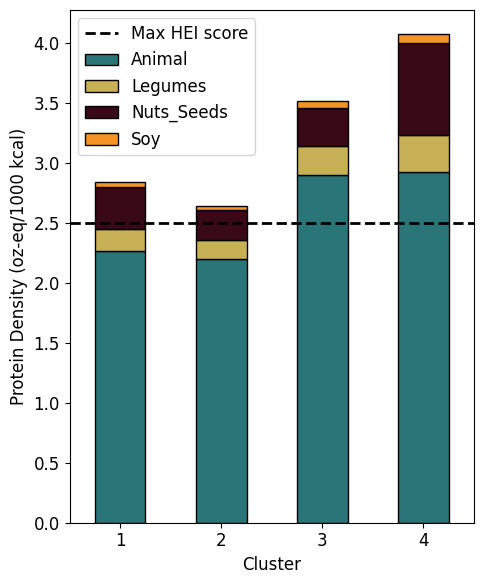

In [ ]:
# Bring back into python to then code
python_protein = pandas2ri.rpy2py(robjects.globalenv['stacked_protein'])

print(python_protein)

# Pivot the data for stacking
pivot_df = python_protein.pivot_table(index='cluster', columns='Protein_Type', values='Density (oz-eq/1000 kcal)', aggfunc='sum')

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(5, 6))

# Create the stacked bar chart
pivot_df.plot(
    kind='bar',
    stacked=True,
    color=our_palette[2:6], ax=ax,
    edgecolor='black'
)

# Add a vertical dotted line at x=2.5 (or any other x value you want)
ax.axhline(y=2.5, color='black', linestyle='--', linewidth=2, label = 'Max HEI score')

# Customize the plot
# ax.set_title('Protein Density by Cluster and Source')
ax.set_xlabel('Cluster')
ax.set_ylabel('Protein Density (oz-eq/1000 kcal)')
plt.xticks(rotation=0)

# Add legend (including both bar colors and the dotted line)
ax.legend(
    loc='upper left',
    fontsize=12
    # bbox_to_anchor=(1.0, 0.5)
)

# Show the plot
plt.tight_layout()
fig.savefig('outputs/paper/protein.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
%%R
# Quantiles
ppp_table <- svyby(
    formula = ~total_protein_density,
    by = ~cluster,
    design = design,
    FUN = svyquantile,
    quantiles = c(0, 0.25, 0.5, 0.75, 1),
    na.rm = TRUE
)
ppp_table

  cluster total_protein_density.0 total_protein_density.0.25
1       1                       0                   2.041223
2       2                       0                   1.840944
3       3                       0                   2.355707
4       4                       0                   2.884908
  total_protein_density.0.5 total_protein_density.0.75 total_protein_density.1
1                  2.677238                   3.465889                8.644919
2                  2.515704                   3.303939                7.656135
3                  3.301709                   4.463336               15.369311
4                  3.890289                   5.032035               15.217157
  se.total_protein_density.0 se.total_protein_density.0.25
1                        NaN                    0.04894036
2                        NaN                    0.04607566
3                 0.01139552                    0.04823903
4                        NaN                    0.05126105
  se.

In [ ]:
%%R
# Slightly cleaner table
clean_ppp <- ppp_table %>%
  select(!starts_with('se')) %>%
  mutate(across(where(is.numeric), ~ format(round(.x, 2), nsmall = 2))) %>%
  setNames(c(
    'Cluster',
    'Min',
    '25%',
    'Median',
    '75%',
    'Max'
  ))
clean_ppp

  Cluster  Min  25% Median  75%   Max
1       1 0.00 2.04   2.68 3.47  8.64
2       2 0.00 1.84   2.52 3.30  7.66
3       3 0.00 2.36   3.30 4.46 15.37
4       4 0.00 2.88   3.89 5.03 15.22


In [ ]:
%%R
# ANOVA: Conduct an anova across all plant-based proteins
tot_anova <- svyglm(total_protein_density ~ cluster, design)
anovas$total_protein <- regTermTest(tot_anova, 'cluster')
tot_anova_summary <- summary(tot_anova)
print(tot_anova_summary)

leg_anova <- svyglm(pf_legumes_density ~ cluster, design)
anovas$legumes <- regTermTest(leg_anova, 'cluster')
leg_anova_summary <- summary(leg_anova)
print(leg_anova_summary)

soy_anova <- svyglm(pf_soy_density ~ cluster, design)
anovas$soy <- regTermTest(soy_anova, 'cluster')
soy_anova_summary <- summary(soy_anova)
print(soy_anova_summary)

nut_anova <- svyglm(pf_nutsds_density ~ cluster, design)
anovas$nuts_seeds <- regTermTest(nut_anova, 'cluster')
nut_anova_summary <- summary(nut_anova)
print(nut_anova_summary)

# If p < 0.05, suggests differences between groups


Call:
svyglm(formula = total_protein_density ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.84001    0.03812  74.498  < 2e-16 ***
cluster2    -0.19912    0.04736  -4.204 0.000159 ***
cluster3     0.67486    0.04896  13.783 3.78e-16 ***
cluster4     1.23407    0.06679  18.476  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 2.224589)

Number of Fisher Scoring iterations: 2


Call:
svyglm(formula = pf_legumes_density ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.18453    0.01479  12.479 7.92e-15 ***
cluster2    -0.01877    0.01591  -1.180  0.24563    
cluster3     0

In [ ]:
%%R
# Posthoc test
(posthocs$protein <- get_posthoc('total_protein_density', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -4.204  39   0.000   *
2       1       3   13.783  39   0.000   *
3       1       4   18.476  39   0.000   *
4       2       3   19.885  39   0.000   *
5       2       4   29.400  39   0.000   *
6       3       4    8.082  39   0.000   *


## HEI

### Components

Throwing together some summaries for the 13 HEI compents so we can get a better sense of what each cluster is up to.

In [ ]:
%%R
# Get names of the 13 HEI components + total HEI score
components <- names(dat) %>%
  str_subset('_density$|(?<!income)_ratio$|_pct$|hei_score')
# print(components)

# Get means and SEs for components
component_table <- map(components, \(x) {
  svyby(
    formula = as.formula(paste0('~', x)),
    by = ~cluster,
    design = design,
    FUN = svymean,
    na.rm = TRUE
  ) %>%
  mutate(across(where(is.numeric), ~ format(round(.x, 2), nsmall = 2))) %>%
  # mutate(!!sym(x) := paste0(!!sym(x), ' (', se, ')')) %>%
  select(-se) %>%
  t() %>%
  as.data.frame() %>%
  setNames(c(paste('Cluster', names(.)))) %>%
  rownames_to_column('Component') %>%
  slice(-1)
}) %>%
  bind_rows()
print(component_table)


                   Component Cluster 1 Cluster 2 Cluster 3 Cluster 4
1                  hei_score     36.15     34.39     43.98     53.71
2        total_fruit_density      0.26      0.29      0.53      0.74
3        whole_fruit_density      0.20      0.21      0.42      0.61
4   total_vegetables_density      0.59      0.54      0.84      1.30
5   greens_and_beans_density      0.09      0.08      0.15      0.25
6       whole_grains_density      0.33      0.36      0.46      0.47
7              dairy_density      0.93      0.75      0.63      0.52
8      total_protein_density      2.84      2.64      3.51      4.07
9  sea_plant_protein_density      0.77      0.63      0.98      1.62
10    refined_grains_density      2.81      2.94      2.55      2.02
11            sodium_density      1.59      1.55      1.68      1.65
12          fatty_acid_ratio      1.69      1.67      1.95      2.27
13           added_sugar_pct     12.41     15.30     10.66      7.16
14        fatty_acid_mod_pct     1

In [ ]:
%%R
# Clean up the table names
clean_table <- component_table %>%
  mutate(
    Component = Component %>%
      str_remove('_density') %>%
      str_replace_all('_', ' ') %>%
      str_to_title() %>%
      str_remove(' Pct') %>%
      str_remove(' Mod') %>%
      str_replace('Hei', 'HEI') %>%
      str_replace('Acid', 'Acids') %>%
      str_replace('Sea ', 'Seafood/')
  )
# print(clean_table)

# Add units to row headers
clean_table <- clean_table %>%
  mutate(
    Component = case_when(
      str_detect(Component, 'Fruit|Veg|Green|Dairy') ~ paste(Component, '(cups/1,000 kcal)'),
      str_detect(Component, 'Whole Grain|Total Protein|Sea|Refine') ~ paste(Component, '(oz/1,000 kcal)'),
      str_detect(Component, 'Sodium') ~ paste(Component, '(g/1,000 kcal)'),
      str_detect(Component, 'Added|Acids$') ~ paste(Component, '(% of kcal)'),
      str_detect(Component, 'Ratio') ~ paste(Component, '((PUFA + MUFA)/SFA)')
    ) %>%
    str_remove(' Ratio')
  )
# print(clean_table)

# Rearrange to match the sheet
clean_table <- clean_table %>%
  slice(2:9, 12, 10:11, 13:14)

print(clean_table)

                               Component Cluster 1 Cluster 2 Cluster 3
1          Total Fruit (cups/1,000 kcal)      0.26      0.29      0.53
2          Whole Fruit (cups/1,000 kcal)      0.20      0.21      0.42
3     Total Vegetables (cups/1,000 kcal)      0.59      0.54      0.84
4     Greens And Beans (cups/1,000 kcal)      0.09      0.08      0.15
5           Whole Grains (oz/1,000 kcal)      0.33      0.36      0.46
6                Dairy (cups/1,000 kcal)      0.93      0.75      0.63
7          Total Protein (oz/1,000 kcal)      2.84      2.64      3.51
8  Seafood/Plant Protein (oz/1,000 kcal)      0.77      0.63      0.98
9        Fatty Acids ((PUFA + MUFA)/SFA)      1.69      1.67      1.95
10        Refined Grains (oz/1,000 kcal)      2.81      2.94      2.55
11                 Sodium (g/1,000 kcal)      1.59      1.55      1.68
12               Added Sugar (% of kcal)     12.41     15.30     10.66
13               Fatty Acids (% of kcal)     13.57     12.72     11.31
   Clu

#### Table

Make an interactive table to explore results. Note that we had to remove the otherwise quite convenient 'value (se)' formatting so that we can actually sort this table properly. Will have to add it back in (if and) before we add the table to the paper.

Also, this format makes sense for the paper, but not for actually exploring the data, because I'd rather sort by the component to see which cluster is the highest or lowest. Alas

In [ ]:
# # Pull from R
component_table = pandas2ri.rpy2py(robjects.globalenv['clean_table'])
component_table
# # Initiate interactive notebook mode
# itables.init_notebook_mode()

# # Show table
# itables.show(component_table, paging=False)

,Component,Cluster 1,Cluster 2,Cluster 3,Cluster 4
1,"Total Fruit (cups/1,000 kcal)",0.26,0.29,0.53,0.74
2,"Whole Fruit (cups/1,000 kcal)",0.20,0.21,0.42,0.61
3,"Total Vegetables (cups/1,000 kcal)",0.59,0.54,0.84,1.30
4,"Greens And Beans (cups/1,000 kcal)",0.09,0.08,0.15,0.25
5,"Whole Grains (oz/1,000 kcal)",0.33,0.36,0.46,0.47
6,"Dairy (cups/1,000 kcal)",0.93,0.75,0.63,0.52
7,"Total Protein (oz/1,000 kcal)",2.84,2.64,3.51,4.07
8,"Seafood/Plant Protein (oz/1,000 kcal)",0.77,0.63,0.98,1.62
9,Fatty Acids ((PUFA + MUFA)/SFA),1.69,1.67,1.95,2.27
10,"Refined Grains (oz/1,000 kcal)",2.81,2.94,2.55,2.02


#### Plots

Same thing, but with colors

In [ ]:
# Melt DF into long format for seaborn
long_df = component_table.melt(
    id_vars='Component',
    value_vars=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
    var_name='Cluster',
    value_name='Value'
)
long_df['Value'] = long_df['Value'].astype(float)
long_df['Cluster'] = long_df['Cluster'].str.replace('Cluster ', '').astype(int)

long_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Component  52 non-null     object 
 1   Cluster    52 non-null     int64  
 2   Value      52 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


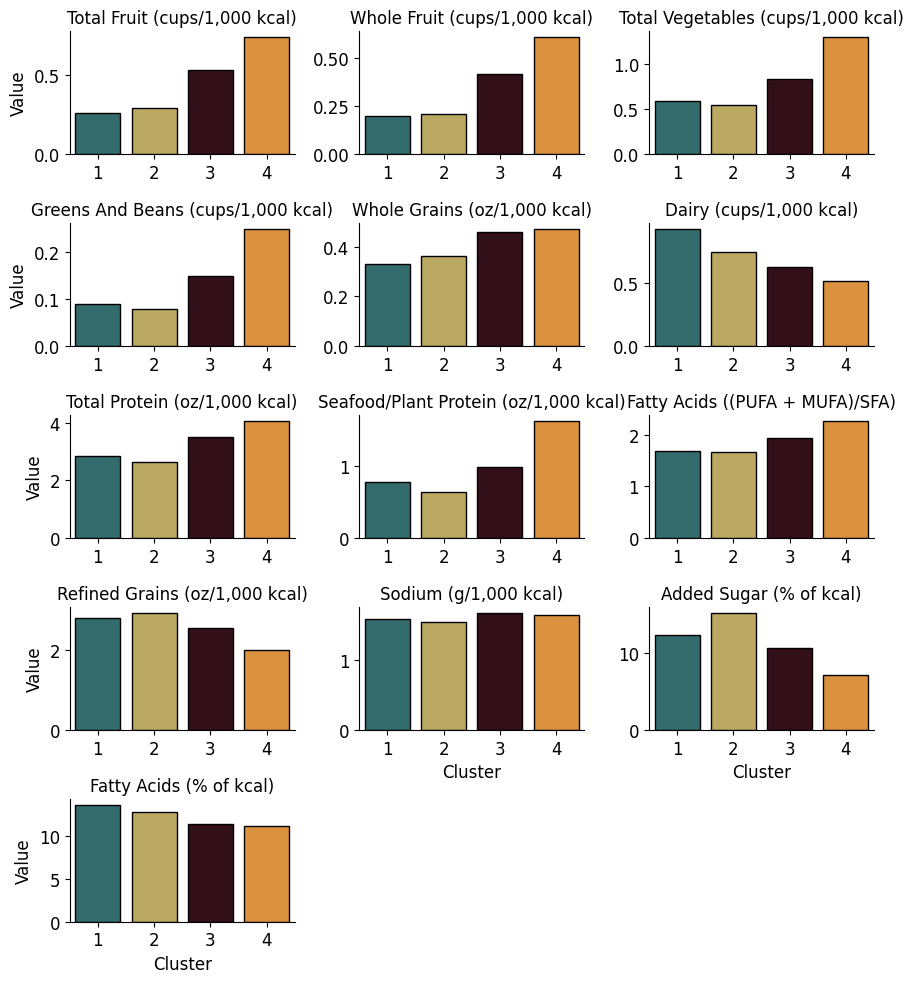

In [ ]:
grid = sns.FacetGrid(
    long_df,
    col="Component",
    col_wrap=3,
    sharey=False,
    sharex=False,
    hue='Cluster',
    palette=our_palette[2:6],
    height=2,
    aspect=1.5
)
grid.map_dataframe(
    sns.barplot,
    x="Cluster",
    y="Value",
    edgecolor='black'
)
grid.set_titles("{col_name}")
grid.set_axis_labels("Cluster", "Value")
plt.tight_layout()
grid.figure.savefig('outputs/paper/HEI_components.png', dpi=300, bbox_inches='tight')
plt.show()

#### Summary

Cluster 1:
- Highest dairy, fatty acids as % of kcal
- 2nd highest refined grains
- 2nd lowest veg, greens and beans, total proteins
- Lowest fruit, lowest whole grains,
- Medium sodium, sugar

1 is overwhelmingly male, youngest of the 4 groups, middle income compared to other groups, least education, 2nd lowest mean HEI score.

Cluster 2:
- highest refined grains, highest sugar (by a lot)
- 2nd highest whole grain (close), dairy, total protein
- 2nd lowest fruit
- lowest veg, greens, seafood/plant protein, fatty acids,sodium

2 is also even split on gender, medium income compared to others, 2nd highest education. Lowest HEI score.

Cluster 3:
- highest sodium
- 2nd highest fruit, veg, greens and beans, whole grains (close to 1st), total protein, seafood/plant protein, fatty acids
- 2nd lowest dairy, refined grains, sugar, fatty acids %

3 is overwhelmingly female, more racial diversity, second oldest, lowest income, 2nd highest HEI score

Cluster 4:
- highest fruit (by a lot), veg (by a lot), greens and beans (by a lot), whole grains (barely), total protein, sea/plant protein (by a lot), fatty acids,
- 2nd highest sodium
- lowest dairy, refined grains, sugar (by a lot), fatty acids %

4 is slightly more male than female, highest income, by far the most educated, best HEI scores by a pretty wide margin.

In [ ]:
%%R
# Curious about alcoholic drinks
svyby(~alcoholic_drinks, ~cluster, design, svymean)
# Interesting - I thought the young male group would be way higher
# Turns out the educated higher income group drinks the most

  cluster alcoholic_drinks         se
1       1        1.6441233 0.13152475
2       2        0.9111507 0.06160041
3       3        0.9535776 0.07201806
4       4        1.7142560 0.07811041


### Scores

In [34]:
%%R
# Means
svyby(~hei_score, ~cluster, design, svymean)

  cluster hei_score        se
1       1  36.15421 0.5533976
2       2  34.38629 0.3251954
3       3  43.98165 0.4549375
4       4  53.71167 0.5233906


In [35]:
%%R
# Quantiles
svyby(
    formula = ~hei_score,
    by = ~cluster,
    design = design,
    FUN = svyquantile,
    quantiles = c(0, 0.25, 0.5, 0.75)
)

  cluster hei_score.0 hei_score.0.25 hei_score.0.5 hei_score.0.75
1       1    7.805323       28.13616      34.47520       43.64183
2       2    5.865052       26.89860      33.62081       40.76037
3       3    7.953240       34.13963      43.55519       52.58950
4       4   23.430460       45.26978      52.56139       61.90075
  se.hei_score.0 se.hei_score.0.25 se.hei_score.0.5 se.hei_score.0.75
1            NaN         0.7652481        0.6800142         0.9073596
2            NaN         0.2899053        0.3473081         0.4742718
3            NaN         0.4482677        0.5644924         0.5969615
4            NaN         0.4843393        0.4868239         0.7763395


In [ ]:
%%R
# ANOVA
mod <- svyglm(hei_score ~ cluster, design)
(anovas$hei <- regTermTest(mod, 'cluster'))
# If p < 0.05, shows differences between groups

Wald test for cluster
 in svyglm(formula = hei_score ~ cluster, design = design)
F =  417.5307  on  3  and  37  df: p= < 2.22e-16 


In [ ]:
%%R
# Posthoc test
(posthocs$hei <- get_posthoc('hei_score', design))

Posthoc tests with Bonferroni correction (alpha = 0.0083)
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -3.504  39   0.001   *
2       1       3   13.993  39   0.000   *
3       1       4   28.069  39   0.000   *
4       2       3   21.987  39   0.000   *
5       2       4   32.371  39   0.000   *
6       3       4   16.901  39   0.000   *


In [ ]:
%%R
# Table to plot with
hei_sum <-svyby(~hei_score, ~cluster, design, svymean)

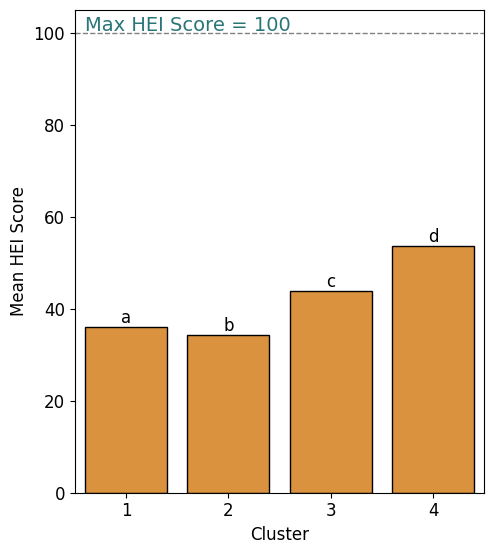

In [ ]:
hei_plot = pandas2ri.rpy2py(robjects.globalenv['hei_sum'])

fig, ax = plt.subplots(figsize=(5, 6))

sns.barplot(
    data=hei_plot,
    x='cluster',
    y='hei_score',
    # yerr=hei_plot['se'],
    color='#f49425',
    edgecolor='black',
    # width=0.5,
    ax=ax
)

# Add CLD letters of significance
letters = ['a', 'b', 'c', 'd']
for i, (cluster, value) in enumerate(zip(hei_plot['cluster'], hei_plot['hei_score'])):
    ax.text(i, value, letters[i], ha='center', va='bottom', color='black')

# plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add horizontal line at score = 100
ax.axhline(y=100, color='gray', linestyle='--', linewidth=1)
ax.text(-0.4, 100.5, 'Max HEI Score = 100', color='#2a7578', fontsize = 14)

# ax.set_title("Mean HEI Score by Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Mean HEI Score")
plt.savefig('outputs/paper/HEI_means.png', format='png', dpi=300)
plt.show()

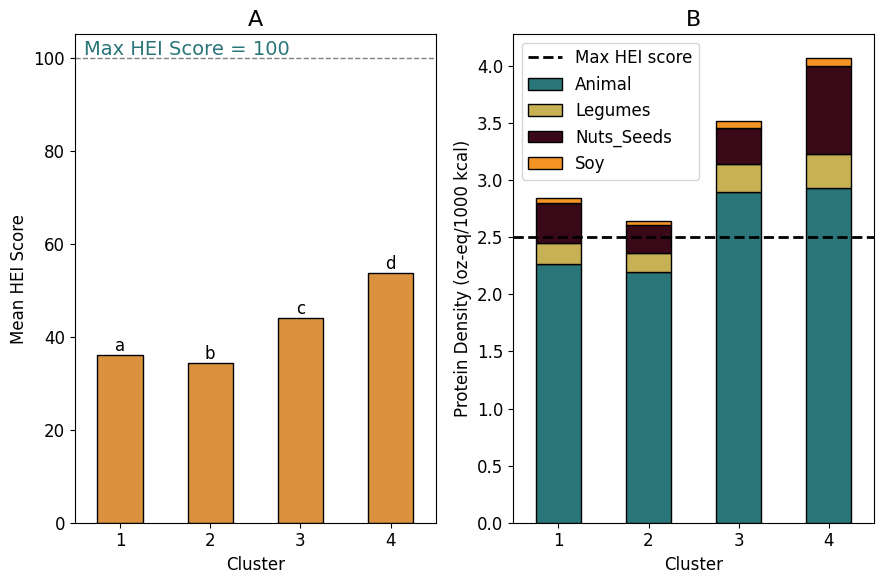

In [ ]:
# Combining HEI scores and Protein scores

# Create the figure and axes objects
fig, axs = plt.subplots(1, 2, figsize=(9, 6))


# HEI Scores --------------------------------------------------------------
sns.barplot(
    data=hei_plot,
    x='cluster',
    y='hei_score',
    color='#f49425',
    edgecolor='black',
    width=0.5,
    ax=axs[0]
)

# Add CLD letters of significance
letters = ['a', 'b', 'c', 'd']
for i, (cluster, value) in enumerate(zip(hei_plot['cluster'], hei_plot['hei_score'])):
    axs[0].text(i, value, letters[i], ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add horizontal line at score = 100
axs[0].axhline(y=100, color='gray', linestyle='--', linewidth=1)
axs[0].text(-0.4, 100.5, 'Max HEI Score = 100', color='#2a7578', fontsize = 14)

# ax.set_title("Mean HEI Score by Cluster")
axs[0].set_title("A")
axs[0].set_xlabel("Cluster")
axs[0].set_ylabel("Mean HEI Score")


# Protein ----------------------------------------------
pivot_df.plot(
    kind='bar',
    stacked=True,
    color=our_palette[2:6],
    edgecolor='black',
    ax=axs[1]
)

# Add a vertical dotted line at x=2.5 (or any other x value you want)
axs[1].axhline(y=2.5, color='black', linestyle='--', linewidth=2, label = 'Max HEI score')

# Customize the plot
# ax.set_title('Protein Density by Cluster and Source')
axs[1].set_title("B")
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Protein Density (oz-eq/1000 kcal)')
plt.xticks(rotation=0)

# Add legend (including both bar colors and the dotted line)
axs[1].legend(
    loc='upper left',
    fontsize=12
)

# Show the plot
plt.tight_layout()
fig.savefig('outputs/paper/hei_and_protein.png', dpi=300, bbox_inches='tight')
plt.show()

## Wrangle Tables


### ANOVAs

(and chi squares)

In [ ]:
%%R
# Get all the anovas from R together

# print(names(anovas))
# print(anovas)
# print(str(anovas[[1]]))

anova_table <- imap(anovas, ~ {
  data.frame(
      name = .y,
      stat = 'F',
      value = .x$Ftest,
      df = .x$df,
      p = .x$p
  )
}) %>%
  bind_rows()
print(anova_table)

                name stat      value df            p
1             gender    F 129.068616  3 1.195351e-19
2                age    F  36.606739  3 3.643646e-11
3             income    F  38.079080  3 2.115303e-11
4            mercury    F  28.024406  3 1.246403e-09
5  total_cholesterol    F   3.036901  3 4.108953e-02
6           systolic    F   3.961244  3 1.517363e-02
7          diastolic    F   6.530416  3 1.174708e-03
8      total_protein    F 489.010859  3 8.356674e-30
9            legumes    F  16.942468  3 4.349063e-07
10               soy    F  12.512177  3 8.496341e-06
11        nuts_seeds    F  82.824858  3 1.777991e-16
12               hei    F 417.530678  3 1.435686e-28


In [ ]:
# Same treatment for chi squares
race_cont_table.name = 'race'
ed_cont_table.name = 'education'

# make a list of tables, education and race
tables = [race_cont_table, ed_cont_table]

# For each table, get chi2, dof, and p, put into data frame
chi_table = pd.DataFrame(columns=['name', 'stat', 'value', 'df', 'p'])
for table in tables:
    chi2, p, dof, expected = chi2_contingency(table)
    # add new row to chi_table
    chi_table = pd.concat([chi_table, pd.DataFrame({
        'name': [table.name],
        'stat': ['Chi2'],
        'value': [chi2],
        'df': [dof],
        'p': [p]
    })], ignore_index=True)

chi_table

<ipython-input-105-71d3b72c3cbf>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chi_table = pd.concat([chi_table, pd.DataFrame({


,name,stat,value,df,p
0,race,Chi2,759.869377,3,2.184446e-164
1,education,Chi2,389.759411,15,9.790914e-74


In [ ]:
# Pull anova table into python, then combine with chi squares
anova_table = pandas2ri.rpy2py(robjects.globalenv['anova_table'])
anova_table = pd.concat([anova_table, chi_table], ignore_index=True)
# print(anova_table)

# Reorganize by name. Demos, then, hei, PBPs, then biomarkers
order = ['gender', 'age', 'race', 'income', 'education', 'total_protein',
         'legumes', 'soy', 'nuts_seeds', 'hei', 'total_cholesterol', 'systolic',
         'diastolic', 'mercury']
anova_table.sort_values(by='name', key=lambda x: x.map({v: i for i, v in enumerate(order)}), inplace=True)

# Clean up names
anova_table['name'] = anova_table['name'] \
  .str.replace('nuts_seeds', 'nuts and seeds') \
  .str.replace('_', ' ') \
  .str.replace('legumes', 'legume protein') \
  .str.replace('soy', 'soy protein') \
  .str.replace('total cholesterol', 'cholesterol') \
  .str.replace('mercury', 'blood mercury') \
  .str.title() \
  .str.replace('Systolic', 'Systolic BP') \
  .str.replace('Diastolic', 'Diastolic BP') \
  .str.replace('Hei', 'HEI') \
  .str.replace('Nuts And Seeds', 'Nut and Seed Protein')

# Make Chi Square pretty
anova_table['stat'] = anova_table['stat'].apply(
    lambda x: x.replace('Chi2', '$\chi^2$')
)

# Format Value and P
anova_table['value'] = anova_table['value'].apply(lambda x: f'{x:.3f}')
anova_table['p'] = anova_table['p'].apply(lambda x: f'{x:.3f}')

# Clean up column names
anova_table.columns = ['Variable', 'Stat', 'Value', 'DF', 'P']
print(anova_table)

                Variable      Stat    Value  DF      P
0                 Gender         F  129.069   3  0.000
1                    Age         F   36.607   3  0.000
12                  Race  $\chi^2$  759.869   3  0.000
2                 Income         F   38.079   3  0.000
13             Education  $\chi^2$  389.759  15  0.000
7          Total Protein         F  489.011   3  0.000
8         Legume Protein         F   16.942   3  0.000
9            Soy Protein         F   12.512   3  0.000
10  Nut and Seed Protein         F   82.825   3  0.000
11                   HEI         F  417.531   3  0.000
4            Cholesterol         F    3.037   3  0.041
5            Systolic BP         F    3.961   3  0.015
6           Diastolic BP         F    6.530   3  0.001
3          Blood Mercury         F   28.024   3  0.000


In [ ]:
# Export to latex
anova_table.to_latex(
    'outputs/paper/anova_table.tex',
    index=False,
    label='tab:anova_table',
    position='h',
    # float_format="%.3f",
    caption='ANOVAS and Chi Square Tests across Clusters'
)

### Posthocs

In [ ]:
%%R
posthocs

$age
  Group_A Group_B Estimate DoF P_value Sig
1       1       2    3.155  39   0.003   *
2       1       3    9.387  39   0.000   *
3       1       4    7.293  39   0.000   *
4       2       3    4.422  39   0.000   *
5       2       4    5.205  39   0.000   *
6       3       4    1.686  39   0.100    

$income
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -1.235  39   0.224    
2       1       3   -2.550  39   0.015    
3       1       4    5.534  39   0.000   *
4       2       3   -1.672  39   0.103    
5       2       4    8.551  39   0.000   *
6       3       4    9.802  39   0.000   *

$mercury
  Group_A Group_B Estimate DoF P_value Sig
1       1       2   -1.704  39   0.096    
2       1       3    1.960  39   0.057    
3       1       4    7.179  39   0.000   *
4       2       3    4.425  39   0.000   *
5       2       4    8.153  39   0.000   *
6       3       4    5.423  39   0.000   *

$cholesterol
  Group_A Group_B Estimate DoF P_value Sig
1       1       

In [ ]:
%%R
names(posthocs)

[1] "age"         "income"      "mercury"     "cholesterol" "systolic"   
[6] "diastolic"   "protein"     "hei"        


In [ ]:
# get table from R
r_posthocs = pandas2ri.rpy2py(robjects.globalenv['posthocs'])
columns = ['Cluster A', 'Cluster B', 'Value', 'DF', 'P', ' ']

posthocs = []
for i in range(len(r_posthocs)):
  tab = pd.DataFrame(r_posthocs[i]).T
  tab.columns = columns
  tab['Value'] = pd.to_numeric(tab['Value'], errors='coerce')
  tab['P'] = pd.to_numeric(tab['P'], errors='coerce')
  tab['DF'] = pd.to_numeric(tab['DF'], errors='coerce')

  tab['Value'] = tab['Value'].apply(lambda x: f'{x:.3f}')
  tab['P'] = tab['P'].apply(lambda x: f'{x:.3f}')
  tab['DF'] = tab['DF'].apply(lambda x: f'{x:.0f}')
  # drop index
  tab.reset_index(inplace=True, drop=True)
  posthocs.append(tab)
posthocs[0]

,Cluster A,Cluster B,Value,DF,P,
0,1,2,3.155,39,0.003,*
1,1,3,9.387,39,0.000,*
2,1,4,7.293,39,0.000,*
3,2,3,4.422,39,0.000,*
4,2,4,5.205,39,0.000,*
5,3,4,1.686,39,0.100,


In [ ]:
# Save each one
names = ['Age', 'Income', 'Mercury', 'Cholesterol', 'Systolic BP', 'Diastolic BP', 'Protein', 'HEI']
captions = ['Posthoc tests for ' + name + ' with Bonferroni adjustment' for name in names]
paths = [name.replace(' ', '_') for name in names]

for i in range(len(posthocs)):
  posthocs[i].to_latex(
    f'outputs/paper/posthoc_{paths[i]}.tex',
    index=False,
    label=f"tab:posthoc_{paths[i]}",
    position='h',
    # float_format="%.3f",
    caption=captions[i]
  )

# OLD

### Weighted and Unweighted Means: PBP Consumption

In [ ]:
# from IPython.display import display

# # Unweighted means

# means_table = df.groupby('cluster')[['pf_soy_(oz_eq)','pf_legumes_(oz_eq)', 'pf_nutsds_(oz_eq)']].mean()

# display(means_table.round(4))

# # Weighted means

# def weighted_mean(x, value_col, weight_col):
#     return (x[value_col] * x[weight_col]).sum() / x[weight_col].sum()

# weighted_means = df.groupby('cluster').apply(
#     lambda g: pd.Series({
#         'wt_mean_pf_soy_(oz_eq)': weighted_mean(g, 'pf_soy_(oz_eq)', 'weight_2d'),
#         'wt_mean_pf_legumes_(oz_eq)': weighted_mean(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
#         'wt_mean_pf_nutsds_(oz_eq)': weighted_mean(g, 'pf_nutsds_(oz_eq)', 'weight_2d')
#     })
# ).reset_index()

# display(weighted_means.round(4))

### Descriptive Statistics

In [ ]:
# # Descriptive Stats: Unweighted Soy Consumption by Cluster

# descriptive_unweighted = df.groupby('cluster')['pf_soy_(oz_eq)'].describe()
# print(descriptive_unweighted.round(4))

In [ ]:
# # Descriptive Stats: Unweighted Legume Consumption by Cluster

# descriptive_unweighted = df.groupby('cluster')['pf_legumes_(oz_eq)'].describe()
# print(descriptive_unweighted.round(4))

In [ ]:
# # Descriptive Stats: Unweighted Nuts & Seeds Consumption by Cluster

# descriptive_unweighted = df.groupby('cluster')['pf_nutsds_(oz_eq)'].describe()
# print(descriptive_unweighted.round(4))

In [ ]:
# #Descriptive Stats: Weighted Soy Consumption by Cluster

# desc_weighted = df.groupby('cluster').apply(
#     lambda g: pd.Series({
#         'weighted_mean': weighted_mean(g, 'pf_soy_(oz_eq)', 'weight_2d'),
#         'weighted_std': weighted_std(g, 'pf_soy_(oz_eq)', 'weight_2d'),
#         'min': g['pf_soy_(oz_eq)'].min(),
#         '25%': g['pf_soy_(oz_eq)'].quantile(0.25),
#         'median': g['pf_soy_(oz_eq)'].median(),
#         '75%': g['pf_soy_(oz_eq)'].quantile(0.75),
#         'max': g['pf_soy_(oz_eq)'].max(),
#     })
# ).reset_index()

# print(desc_weighted.round(3).to_string(index=False))

In [ ]:
# #Descriptive Stats: Weighted Legume Consumption by Cluster

# desc_weighted = df.groupby('cluster').apply(
#     lambda g: pd.Series({
#         'weighted_mean': weighted_mean(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
#         'weighted_std': weighted_std(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
#         'min': g['pf_legumes_(oz_eq)'].min(),
#         '25%': g['pf_legumes_(oz_eq)'].quantile(0.25),
#         'median': g['pf_legumes_(oz_eq)'].median(),
#         '75%': g['pf_legumes_(oz_eq)'].quantile(0.75),
#         'max': g['pf_legumes_(oz_eq)'].max(),
#     })
# ).reset_index()

# print(desc_weighted.round(3).to_string(index=False))

In [ ]:
# #Descriptive Stats: Weighted Nuts & Seeds Consumption by Cluster

# desc_weighted = df.groupby('cluster').apply(
#     lambda g: pd.Series({
#         'weighted_mean': weighted_mean(g, 'pf_nutsds_(oz_eq)', 'weight_2d'),
#         'weighted_std': weighted_std(g, 'pf_nutsds_(oz_eq)', 'weight_2d'),
#         'min': g['pf_nutsds_(oz_eq)'].min(),
#         '25%': g['pf_nutsds_(oz_eq)'].quantile(0.25),
#         'median': g['pf_nutsds_(oz_eq)'].median(),
#         '75%': g['pf_nutsds_(oz_eq)'].quantile(0.75),
#         'max': g['pf_nutsds_(oz_eq)'].max(),
#     })
# ).reset_index()

# print(desc_weighted.round(3).to_string(index=False))